In [4]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

In [5]:
conf = (SparkConf()
            .setMaster("yarn")
            .set("spark.executor.cores", 5)
            .set("spark.sql.shuffle.partitions", 200)
            .set("spark.default.parallelism", 200)
            .set("spark.executor.memory", "7g")
            .set("spark.dynamicAllocation.maxExecutors", 20)
        )

spark = SparkSession \
    .builder \
    .config(conf=conf) \
    .appName("Test_PySpark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [15]:
# Ejemplo de creación de un DataFrame a partir de los datos almacenados en HDFS
df = spark.read \
          .option("header","true") \
          .option("inferSchema", "true") \
          .csv("/datos/gittba26/gittba10/bronce/LINK")

In [16]:
df.printSchema()

root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



In [17]:
df.show()

[Stage 19:>                                                         (0 + 1) / 1]

+----------+----------+----------+----------+----------+------------------+----+-----+
|      date|      open|      high|       low|     close|            volume|year|month|
+----------+----------+----------+----------+----------+------------------+----+-----+
|2024-05-01|13.1412687|13.5671928|12.3938758|13.3468614| 319604.4699999998|2024|    5|
|2024-05-02|13.3408292|13.8018963| 12.934852|13.6040873|137790.47000000038|2024|    5|
|2024-05-03|13.5992045|14.2089571| 13.470351|14.0974049|181321.24999999997|2024|    5|
|2024-05-04|14.1013886|14.4886998| 13.987964| 14.319916|151191.83000000002|2024|    5|
|2024-05-05|14.3399506|14.6649421|14.1161335|14.3834613| 98370.21000000015|2024|    5|
|2024-05-06|14.3874776|15.1696417|14.2994557|14.4952974|203470.25000000026|2024|    5|
|2024-05-07|14.4939256|14.7204727|13.9697015|14.0035158|181185.62000000017|2024|    5|
|2024-05-08|14.0094497|14.1144736|13.6977612|13.9008841|166258.99000000022|2024|    5|
|2024-05-09|13.8955722|14.3825288|13.842560

In [18]:
df.count()

1500

In [19]:
from pyspark.sql import functions as F

# df ya lo tienes cargado
df_2025 = (
    df
    .filter(F.col("year") == 2025)      # o F.year("date")==2025 si no tuvieras la columna year
    .select("date", "close")
    .orderBy("date")
)

df_2025.show(5)

+----------+----------+
|      date|     close|
+----------+----------+
|2025-01-01|21.7014473|
|2025-01-02|22.0573078|
|2025-01-03|23.4652501|
|2025-01-04|23.5949517|
|2025-01-05|23.5633733|
+----------+----------+
only showing top 5 rows



[Stage 23:========================================================(12 + 2) / 12]

In [20]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, DateType, DoubleType

schema = StructType([
    StructField("date", DateType(), True),
    StructField("close", DoubleType(), True),
    StructField("macd", DoubleType(), True),
    StructField("signal", DoubleType(), True),
])

def macd_calc(pdf: pd.DataFrame) -> pd.DataFrame:
    pdf = pdf.sort_values("date")
    close = pd.to_numeric(pdf["close"], errors="coerce")

    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span=9, adjust=False).mean()

    out = pdf[["date", "close"]].copy()
    out["macd"] = macd
    out["signal"] = signal
    return out

df_macd_2025 = (
    df_2025
    .withColumn("_k", F.lit(1))                 # clave única (solo LINK)
    .groupBy("_k")
    .applyInPandas(macd_calc, schema=schema)
    .drop("_k")
    .orderBy("date")
)

df_macd_2025.show(5)

[Stage 30:>                                                         (0 + 1) / 1]

+----------+----------+--------------------+--------------------+
|      date|     close|                macd|              signal|
+----------+----------+--------------------+--------------------+
|2025-01-01|21.7014473|                 0.0|                 0.0|
|2025-01-02|22.0573078|0.028387732193731807|0.005677546438746362|
|2025-01-03|23.4652501|  0.1626198114658166| 0.03706599944416041|
|2025-01-04|23.5949517| 0.27628074409818026| 0.08490894837496439|
|2025-01-05|23.5633733| 0.35966375919079496| 0.13985991053813052|
+----------+----------+--------------------+--------------------+
only showing top 5 rows



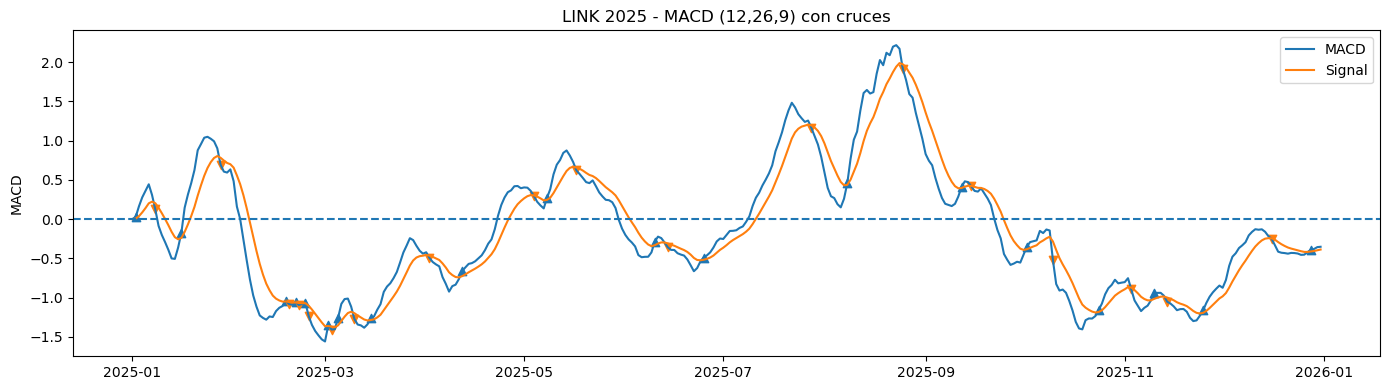

In [21]:
import matplotlib.pyplot as plt

pdf = df_macd_2025.toPandas().sort_values("date").reset_index(drop=True)

cross_up = (pdf["macd"].shift(1) <= pdf["signal"].shift(1)) & (pdf["macd"] > pdf["signal"])
cross_dn = (pdf["macd"].shift(1) >= pdf["signal"].shift(1)) & (pdf["macd"] < pdf["signal"])

plt.figure(figsize=(14,4))
plt.plot(pdf["date"], pdf["macd"], label="MACD")
plt.plot(pdf["date"], pdf["signal"], label="Signal")
plt.axhline(0, linestyle="--")

plt.scatter(pdf.loc[cross_up, "date"], pdf.loc[cross_up, "macd"], marker="^")
plt.scatter(pdf.loc[cross_dn, "date"], pdf.loc[cross_dn, "macd"], marker="v")

plt.title("LINK 2025 - MACD (12,26,9) con cruces")
plt.ylabel("MACD")
plt.legend()
plt.tight_layout()
plt.show()